In [1]:
import pandas as pd
import requests
from bs4 import BeautifulSoup

import plotly.graph_objs as go
import plotly.figure_factory as ff
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

import geopandas as gpd
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [16,9]

import numpy as np
import json

1. Obtain the [current dataset](https://npgeo-corona-npgeo-de.hub.arcgis.com/datasets/dd4580c810204019a7b8eb3e0b329dd6_0) provided by the RKI (you can directly read in the `.geojson`). Which Python library can handle geospatial data well?

In [2]:
corona_data = gpd.read_file("https://opendata.arcgis.com/datasets/dd4580c810204019a7b8eb3e0b329dd6_0.geojson") # can take a while (~5 mins) to load...

In [3]:
len(corona_data)

1641234

In [151]:
corona_data.head()

,ObjectId,IdBundesland,Bundesland,Landkreis,Altersgruppe,Geschlecht,AnzahlFall,AnzahlTodesfall,Meldedatum,IdLandkreis,Datenstand,NeuerFall,NeuerTodesfall,Refdatum,NeuGenesen,AnzahlGenesen,IstErkrankungsbeginn,Altersgruppe2,geometry,MeldedatumISO
0,1,1,Schleswig-Holstein,SK Flensburg,A00-A04,M,1,0,2020-09-30 00:00:00+00:00,01001,"13.04.2021, 00:00 Uhr",0,-9,2020-09-30T00:00:00+00:00,0,1,0,Nicht übermittelt,None,2020-09-30
1,2,1,Schleswig-Holstein,SK Flensburg,A00-A04,M,1,0,2020-10-29 00:00:00+00:00,01001,"13.04.2021, 00:00 Uhr",0,-9,2020-10-29T00:00:00+00:00,0,1,0,Nicht übermittelt,None,2020-10-29
2,3,1,Schleswig-Holstein,SK Flensburg,A00-A04,M,1,0,2020-11-03 00:00:00+00:00,01001,"13.04.2021, 00:00 Uhr",0,-9,2020-11-03T00:00:00+00:00,0,1,0,Nicht übermittelt,None,2020-11-03
3,4,1,Schleswig-Holstein,SK Flensburg,A00-A04,M,1,0,2020-11-20 00:00:00+00:00,01001,"13.04.2021, 00:00 Uhr",0,-9,2020-11-19T00:00:00+00:00,0,1,1,Nicht übermittelt,None,2020-11-20
4,5,1,Schleswig-Holstein,SK Flensburg,A00-A04,M,1,0,2020-11-23 00:00:00+00:00,01001,"13.04.2021, 00:00 Uhr",0,-9,2020-11-18T00:00:00+00:00,0,1,1,Nicht übermittelt,None,2020-11-23


In [4]:
corona_data['MeldedatumISO'] = pd.to_datetime(corona_data['Meldedatum']).dt.strftime('%Y-%m-%d')

In [5]:
corona_data['Meldedatum'] = pd.to_datetime(corona_data['Meldedatum'])

1. Aggregate `AnzahlFall` by day on Landkreis level and store it in a Pandas DataFrame object `landkreis_df`.

In [152]:
landkreis_df = corona_data.groupby(['IdLandkreis', 'MeldedatumISO'])[['AnzahlFall']].agg('sum')
landkreis_df = landkreis_df.stack().to_frame().reset_index()
landkreis_df.columns = ['IdLandkreis', 'MeldedatumISO', 'Indicator', 'Anzahl']

In [153]:
landkreis_df.head()

,IdLandkreis,MeldedatumISO,Indicator,Anzahl
0,01001,2020-03-14,AnzahlFall,4
1,01001,2020-03-18,AnzahlFall,2
2,01001,2020-03-19,AnzahlFall,4
3,01001,2020-03-20,AnzahlFall,2
4,01001,2020-03-21,AnzahlFall,1


2. Obtain `geometries` (i.e. polygons) of `Landkreis` and store it in a Pandas DataFrame object `landkreis_data`.

In [155]:
landkreis_data = gpd.read_file("https://opendata.arcgis.com/datasets/917fc37a709542548cc3be077a786c17_0.geojson")
landkreis_data.head()

,OBJECTID,ADE,GF,BSG,RS,AGS,SDV_RS,GEN,BEZ,IBZ,...,cases7_bl_per_100k,cases7_bl,death7_bl,cases7_lk,death7_lk,cases7_per_100k_txt,AdmUnitId,SHAPE_Length,SHAPE_Area,geometry
0,1,4.0,4.0,1.0,01001,01001,010010000000,Flensburg,Kreisfreie Stadt,40.0,...,70.769995,2055,0,49,0,"54,3",1001,0.524721,0.006873,"MULTIPOLYGON (((9.41266 54.82264, 9.41318 54.8..."
1,2,4.0,4.0,1.0,01002,01002,010020000000,Kiel,Kreisfreie Stadt,40.0,...,70.769995,2055,0,188,0,"76,2",1002,1.274684,0.015507,"MULTIPOLYGON (((10.16916 54.43138, 10.16957 54..."
2,3,4.0,4.0,1.0,01003,01003,010030000000,Lübeck,Kreisfreie Stadt,40.0,...,70.769995,2055,0,154,0,"71,1",1003,1.834534,0.028928,"MULTIPOLYGON (((10.87683 53.98737, 10.87884 53..."
3,4,4.0,4.0,1.0,01004,01004,010040000000,Neumünster,Kreisfreie Stadt,40.0,...,70.769995,2055,0,65,0,"81,1",1004,0.663262,0.009808,"MULTIPOLYGON (((9.99545 54.14972, 9.99713 54.1..."
4,5,4.0,4.0,1.0,01051,01051,010510044044,Dithmarschen,Kreis,42.0,...,70.769995,2055,0,71,0,"53,3",1051,3.073353,0.196087,"MULTIPOLYGON (((8.69258 54.06045, 8.69364 54.0..."


3. Drop all columns except `RS` and `geometry`.

In [156]:
landkreis_shapes = landkreis_data[['RS', 'geometry']]

4. Join the Landkreis `geometry` from left to the aggregated daily cases and store the resulting table in a Pandas DataFrame object `landkreis_merged_df`.

In [157]:
landkreis_merged_df = landkreis_df.merge(landkreis_shapes, left_on='IdLandkreis', right_on = 'RS', how = 'left')

5. Convert the `MeldedatumISO` column into a Pandas `datetime` object (if it's not already - how can you check?) and assign it as the index for the object `landkreis_merged_df`.

In [158]:
landkreis_merged_df['MeldedatumISO'] = pd.to_datetime(landkreis_merged_df['MeldedatumISO'])
landkreis_merged_df.set_index(landkreis_merged_df['MeldedatumISO'], inplace=True)
del landkreis_merged_df['MeldedatumISO']

6. On which day was the first Corona case recorded? Where?

In [159]:
first_date = landkreis_merged_df.index.min()
landkreis_merged_df.loc[first_date]

IdLandkreis                                                05315
Indicator                                             AnzahlFall
Anzahl                                                         1
RS                                                         05315
geometry       (POLYGON ((6.914502590000041 51.05635779700003...
Name: 2020-01-07 00:00:00, dtype: object

7. How many distinct values for `IdLandkreis` are in the dataset?

In [160]:
len(landkreis_merged_df['IdLandkreis'].unique())

412

8. For each `IdLandkreis` compute the date of first occurrence of a Corona case. Find the date from which on the Corona virus was spread over all Landkreise. How long did it take from the first registered case to spread over all Landkreise?

In [161]:
first_record_list = []

for landkreis in landkreis_merged_df['IdLandkreis'].unique():
    
    empty_dict = {}
    
    sub_df = landkreis_merged_df[landkreis_merged_df['IdLandkreis'] == landkreis]
    first_case_recorded_landkreis = sub_df.index.min()
    
    empty_dict['IdLandkreis'] = landkreis
    empty_dict['First case on'] = first_case_recorded_landkreis
    
    first_record_list.append(empty_dict) 

In [162]:
first_record_df = pd.DataFrame(first_record_list)

max_date = first_record_df['First case on'].max()

min_date = first_record_df['First case on'].min()

max_date - min_date

Timedelta('73 days 00:00:00')

9. Create a subset of `landkreis_merged_df` that includes only dates since the day the virus was spread over all Landkreise.

In [163]:
final_landkreis_df = landkreis_merged_df.loc[landkreis_merged_df.index >=max_date]
final_landkreis_df.head()

,IdLandkreis,Indicator,Anzahl,RS,geometry
MeldedatumISO,,,,,
2020-03-20,01001,AnzahlFall,2,01001,"MULTIPOLYGON (((9.41266 54.82264, 9.41318 54.8..."
2020-03-21,01001,AnzahlFall,1,01001,"MULTIPOLYGON (((9.41266 54.82264, 9.41318 54.8..."
2020-03-24,01001,AnzahlFall,1,01001,"MULTIPOLYGON (((9.41266 54.82264, 9.41318 54.8..."
2020-03-26,01001,AnzahlFall,4,01001,"MULTIPOLYGON (((9.41266 54.82264, 9.41318 54.8..."
2020-03-27,01001,AnzahlFall,1,01001,"MULTIPOLYGON (((9.41266 54.82264, 9.41318 54.8..."


In [164]:
date_placeholder = pd.DataFrame(pd.date_range(start=max_date, end=landkreis_merged_df.index.max(), freq='D'))
date_placeholder.columns = ['Date']

In [165]:
date_placeholder

,Date
0,2020-03-20
1,2020-03-21
2,2020-03-22
3,2020-03-23
4,2020-03-24
...,...
384,2021-04-08
385,2021-04-09
386,2021-04-10
387,2021-04-11


In [175]:
complete_df_list = []

for i in range(len(date_placeholder)):
    
    date = date_placeholder.loc[i]['Date']
    
    print("Checking date: " + str(date))
    
    sub_df = final_landkreis_df.loc[date]
    sub_df['was_missing'] = 0
    
    missing_landkreise = [landkreis for landkreis in landkreis_merged_df['RS'].unique() if landkreis not in sub_df['IdLandkreis'].unique()]
    
    missing_list = []
    
    for missing_landkreis in missing_landkreise:
        
        empty_dict = {}
        
        empty_dict['IdLandkreis'] = missing_landkreis
        empty_dict['Indicator'] = 'AnzahlFall'
        empty_dict['Anzahl'] = 0
        empty_dict['RS'] = missing_landkreis
        empty_dict['geometry'] = landkreis_merged_df[landkreis_merged_df['RS'] == missing_landkreis]['geometry'].unique()[0]
        empty_dict['was_missing'] = 1
        empty_dict['Date'] = date
        
        missing_list.append(empty_dict)
        
    missing_df = pd.DataFrame(missing_list)
    missing_df.set_index(missing_df['Date'], inplace = True)
    del missing_df['Date']
    
    sub_df_complete = sub_df.append(missing_df)
    
    complete_df_list.append(sub_df_complete)

Checking date: 2020-03-20 00:00:00
Checking date: 2020-03-21 00:00:00
Checking date: 2020-03-22 00:00:00
Checking date: 2020-03-23 00:00:00
Checking date: 2020-03-24 00:00:00
Checking date: 2020-03-25 00:00:00
Checking date: 2020-03-26 00:00:00
Checking date: 2020-03-27 00:00:00
Checking date: 2020-03-28 00:00:00
Checking date: 2020-03-29 00:00:00
Checking date: 2020-03-30 00:00:00
Checking date: 2020-03-31 00:00:00
Checking date: 2020-04-01 00:00:00
Checking date: 2020-04-02 00:00:00
Checking date: 2020-04-03 00:00:00
Checking date: 2020-04-04 00:00:00
Checking date: 2020-04-05 00:00:00
Checking date: 2020-04-06 00:00:00
Checking date: 2020-04-07 00:00:00
Checking date: 2020-04-08 00:00:00
Checking date: 2020-04-09 00:00:00
Checking date: 2020-04-10 00:00:00
Checking date: 2020-04-11 00:00:00
Checking date: 2020-04-12 00:00:00
Checking date: 2020-04-13 00:00:00
Checking date: 2020-04-14 00:00:00
Checking date: 2020-04-15 00:00:00
Checking date: 2020-04-16 00:00:00
Checking date: 2020-

KeyError: 'Date'

In [178]:
missing_list

[]

In [144]:
landkreis_shapes[landkreis_shapes['county'] == 'LK Saar-Pfalz-Kreis']

,county,geometry
322,LK Saar-Pfalz-Kreis,"MULTIPOLYGON (((7.29722 49.40458, 7.29424 49.4..."


In [140]:
landkreis_merged_df[landkreis_merged_df['Landkreis'] == missing_landkreis]

,Landkreis,Indicator,Anzahl,county,geometry
MeldedatumISO,,,,,
2020-02-27,LK Saarpfalz-Kreis,AnzahlFall,1,NaN,None
2020-03-09,LK Saarpfalz-Kreis,AnzahlFall,2,NaN,None
2020-03-11,LK Saarpfalz-Kreis,AnzahlFall,1,NaN,None
2020-03-13,LK Saarpfalz-Kreis,AnzahlFall,2,NaN,None
2020-03-15,LK Saarpfalz-Kreis,AnzahlFall,7,NaN,None
...,...,...,...,...,...
2021-04-08,LK Saarpfalz-Kreis,AnzahlFall,47,NaN,None
2021-04-09,LK Saarpfalz-Kreis,AnzahlFall,37,NaN,None
2021-04-10,LK Saarpfalz-Kreis,AnzahlFall,23,NaN,None


In [147]:
corona_data.head()

,ObjectId,IdBundesland,Bundesland,Landkreis,Altersgruppe,Geschlecht,AnzahlFall,AnzahlTodesfall,Meldedatum,IdLandkreis,Datenstand,NeuerFall,NeuerTodesfall,Refdatum,NeuGenesen,AnzahlGenesen,IstErkrankungsbeginn,Altersgruppe2,geometry,MeldedatumISO
0,1,1,Schleswig-Holstein,SK Flensburg,A00-A04,M,1,0,2020-09-30 00:00:00+00:00,01001,"13.04.2021, 00:00 Uhr",0,-9,2020-09-30T00:00:00+00:00,0,1,0,Nicht übermittelt,None,2020-09-30
1,2,1,Schleswig-Holstein,SK Flensburg,A00-A04,M,1,0,2020-10-29 00:00:00+00:00,01001,"13.04.2021, 00:00 Uhr",0,-9,2020-10-29T00:00:00+00:00,0,1,0,Nicht übermittelt,None,2020-10-29
2,3,1,Schleswig-Holstein,SK Flensburg,A00-A04,M,1,0,2020-11-03 00:00:00+00:00,01001,"13.04.2021, 00:00 Uhr",0,-9,2020-11-03T00:00:00+00:00,0,1,0,Nicht übermittelt,None,2020-11-03
3,4,1,Schleswig-Holstein,SK Flensburg,A00-A04,M,1,0,2020-11-20 00:00:00+00:00,01001,"13.04.2021, 00:00 Uhr",0,-9,2020-11-19T00:00:00+00:00,0,1,1,Nicht übermittelt,None,2020-11-20
4,5,1,Schleswig-Holstein,SK Flensburg,A00-A04,M,1,0,2020-11-23 00:00:00+00:00,01001,"13.04.2021, 00:00 Uhr",0,-9,2020-11-18T00:00:00+00:00,0,1,1,Nicht übermittelt,None,2020-11-23


In [150]:
landkreis_data.iloc[1]

OBJECTID                                                                2
ADE                                                                   4.0
GF                                                                    4.0
BSG                                                                   1.0
RS                                                                  01002
AGS                                                                 01002
SDV_RS                                                       010020000000
GEN                                                                  Kiel
BEZ                                                      Kreisfreie Stadt
IBZ                                                                  40.0
BEM                                                                    --
NBD                                                                    ja
SN_L                                                                   01
SN_R                                  

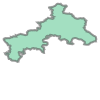

In [130]:
landkreis_merged_df[landkreis_merged_df['Landkreis'] == missing_landkreise[0]]['geometry'].unique()[0]

In [121]:
missing_landkreise = [landkreis for landkreis in landkreis_merged_df['Landkreis'].unique() if landkreis not in sub_df['Landkreis'].unique()]

In [122]:
missing_landkreise

['LK Altenkirchen',
 'LK Anhalt-Bitterfeld',
 'LK Bautzen',
 'LK Bayreuth',
 'LK Biberach',
 'LK Burgenlandkreis',
 'LK Cochem-Zell',
 'LK Darmstadt-Dieburg',
 'LK Diepholz',
 'LK Forchheim',
 'LK Hameln-Pyrmont',
 'LK Haßberge',
 'LK Hildesheim',
 'LK Kronach',
 'LK Leer',
 'LK Lüchow-Dannenberg',
 'LK Lüneburg',
 'LK Mittelsachsen',
 'LK Neumarkt i.d.OPf.',
 'LK Osnabrück',
 'LK Rottweil',
 'LK Sächsische Schweiz-Osterzgebirge',
 'LK Uelzen',
 'LK Verden',
 'LK Waldeck-Frankenberg',
 'LK Wesermarsch',
 'LK Wittmund',
 'SK Berlin Spandau',
 'SK Bremerhaven',
 'SK Darmstadt',
 'SK Hamburg',
 'SK Ingolstadt',
 'SK Landau i.d.Pfalz',
 'SK Neumünster',
 'SK Osnabrück',
 'SK Pirmasens',
 'SK Salzgitter',
 'SK Weiden i.d.OPf.',
 'SK Weimar',
 'SK Wilhelmshaven',
 'SK Wolfsburg',
 'SK Zweibrücken']

In [16]:
landkreis_merged[landkreis_data['county'] == 'SK Berlin Mitte']

,OBJECTID,ADE,GF,BSG,RS,AGS,SDV_RS,GEN,BEZ,IBZ,...,cases7_bl_per_100k,cases7_bl,death7_bl,cases7_lk,death7_lk,cases7_per_100k_txt,AdmUnitId,SHAPE_Length,SHAPE_Area,geometry
409,413,NaN,NaN,NaN,11001,None,None,Berlin Mitte,Bezirk,NaN,...,119.880387,4399,4,515,0,"137,2",11001,0.438594,0.005218,"MULTIPOLYGON (((13.37721 52.56091, 13.37727 52..."


In [71]:
corona_data[(corona_data['Meldedatum'] > '2021-04-05') & 
            (corona_data['Meldedatum'] <= '2021-04-12') & 
            (corona_data['Bundesland'] == 'Berlin')]['AnzahlFall'].sum()

4389

In [72]:
corona_data[(corona_data['Meldedatum'] == '2021-04-11') & (corona_data['Bundesland'] == 'Berlin')]['AnzahlFall'].sum()

98

In [73]:
corona_data[(corona_data['Meldedatum'] == '2021-04-12') & (corona_data['Bundesland'] == 'Berlin')]['AnzahlFall'].sum()

384

In [74]:
corona_data[(corona_data['Bundesland'] == 'Berlin')]['AnzahlFall'].sum()

153981

In [75]:
corona_data[(corona_data['Bundesland'] == 'Berlin')]['AnzahlTodesfall'].sum()

3126

1. Aggregate by day on Landkreis level

In [78]:
grouped_df = corona_data.groupby(['Landkreis', 'MeldedatumISO'])[['AnzahlFall']].agg('sum')
grouped_df = grouped_df.stack().to_frame().reset_index()

In [79]:
grouped_df.head()

,Landkreis,MeldedatumISO,level_2,0
0,LK Ahrweiler,2020-03-12,AnzahlFall,6
1,LK Ahrweiler,2020-03-13,AnzahlFall,3
2,LK Ahrweiler,2020-03-14,AnzahlFall,1
3,LK Ahrweiler,2020-03-16,AnzahlFall,4
4,LK Ahrweiler,2020-03-17,AnzahlFall,6


In [98]:
# grouped_df[(grouped_df['Landkreis'] == 'SK Berlin Reinickendorf') & (grouped_df['MeldedatumISO'] == '2021-04-12')]
grouped_df.columns = ['Landkreis', 'MeldedatumISO', 'Indicator', 'Anzahl']

In [101]:
grouped_df

,Landkreis,MeldedatumISO,Indicator,Anzahl
0,LK Ahrweiler,2020-03-12,AnzahlFall,6
1,LK Ahrweiler,2020-03-13,AnzahlFall,3
2,LK Ahrweiler,2020-03-14,AnzahlFall,1
3,LK Ahrweiler,2020-03-16,AnzahlFall,4
4,LK Ahrweiler,2020-03-17,AnzahlFall,6
...,...,...,...,...
122101,StadtRegion Aachen,2021-04-08,AnzahlFall,102
122102,StadtRegion Aachen,2021-04-09,AnzahlFall,174
122103,StadtRegion Aachen,2021-04-10,AnzahlFall,70
122104,StadtRegion Aachen,2021-04-11,AnzahlFall,17


In [88]:
grouped_df[(grouped_df['Landkreis'] == 'SK Berlin Mitte') & (grouped_df['MeldedatumISO'] == '2021-04-12')]['Anzahl'].sum()

45

In [89]:
grouped_df[(grouped_df['Landkreis'] == 'SK Berlin Mitte') & (grouped_df['MeldedatumISO'] == '2021-04-11')]['Anzahl'].sum()

0

In [90]:
grouped_df[(grouped_df['Landkreis'] == 'SK Berlin Mitte') & (grouped_df['MeldedatumISO'] == '2021-04-10')]['Anzahl'].sum()

0

In [91]:
grouped_df[(grouped_df['Landkreis'] == 'SK Berlin Mitte') & (grouped_df['MeldedatumISO'] == '2021-04-09')]['Anzahl'].sum()

119

In [92]:
grouped_df[(grouped_df['Landkreis'] == 'SK Berlin Mitte') & (grouped_df['MeldedatumISO'] == '2021-04-08')]['Anzahl'].sum()

166

In [93]:
grouped_df[(grouped_df['Landkreis'] == 'SK Berlin Mitte') & (grouped_df['MeldedatumISO'] == '2021-04-07')]['Anzahl'].sum()

67

In [94]:
grouped_df[(grouped_df['Landkreis'] == 'SK Berlin Mitte') & (grouped_df['MeldedatumISO'] == '2021-04-06')]['Anzahl'].sum()

115

In [97]:
45 + 0 + 0 + 119 + 166 + 67 + 115

512

In [46]:
corona_data.set_index(pd.to_datetime(df['Publication date'], format='%d.%m.%Y'), inplace = True)

,ObjectId,IdBundesland,Bundesland,Landkreis,Altersgruppe,Geschlecht,AnzahlFall,AnzahlTodesfall,Meldedatum,IdLandkreis,Datenstand,NeuerFall,NeuerTodesfall,Refdatum,NeuGenesen,AnzahlGenesen,IstErkrankungsbeginn,Altersgruppe2,geometry,MeldedatumISO
0,1,1,Schleswig-Holstein,SK Flensburg,A00-A04,M,1,0,2020-09-30T00:00:00+00:00,01001,"13.04.2021, 00:00 Uhr",0,-9,2020-09-30T00:00:00+00:00,0,1,0,Nicht übermittelt,None,2020-09-30
1,2,1,Schleswig-Holstein,SK Flensburg,A00-A04,M,1,0,2020-10-29T00:00:00+00:00,01001,"13.04.2021, 00:00 Uhr",0,-9,2020-10-29T00:00:00+00:00,0,1,0,Nicht übermittelt,None,2020-10-29
2,3,1,Schleswig-Holstein,SK Flensburg,A00-A04,M,1,0,2020-11-03T00:00:00+00:00,01001,"13.04.2021, 00:00 Uhr",0,-9,2020-11-03T00:00:00+00:00,0,1,0,Nicht übermittelt,None,2020-11-03
3,4,1,Schleswig-Holstein,SK Flensburg,A00-A04,M,1,0,2020-11-20T00:00:00+00:00,01001,"13.04.2021, 00:00 Uhr",0,-9,2020-11-19T00:00:00+00:00,0,1,1,Nicht übermittelt,None,2020-11-20
4,5,1,Schleswig-Holstein,SK Flensburg,A00-A04,M,1,0,2020-11-23T00:00:00+00:00,01001,"13.04.2021, 00:00 Uhr",0,-9,2020-11-18T00:00:00+00:00,0,1,1,Nicht übermittelt,None,2020-11-23


In [36]:
corona_data[(corona_data['MeldedatumISO'] == '2021-04-12') & (corona_data['Bundesland'] == 'Berlin')]['AnzahlFall'].sum()

384

In [37]:
corona_data[(corona_data['MeldedatumISO'] == '2021-04-11') & (corona_data['Bundesland'] == 'Berlin')]['AnzahlFall'].sum()

98

In [39]:
corona_data[(corona_data['MeldedatumISO'] == '2021-04-10') & (corona_data['Bundesland'] == 'Berlin')]['AnzahlFall'].sum()

487

In [40]:
corona_data[(corona_data['MeldedatumISO'] == '2021-04-09') & (corona_data['Bundesland'] == 'Berlin')]['AnzahlFall'].sum()

1071

In [41]:
corona_data[(corona_data['MeldedatumISO'] == '2021-04-08') & (corona_data['Bundesland'] == 'Berlin')]['AnzahlFall'].sum()

988

In [42]:
corona_data[(corona_data['MeldedatumISO'] == '2021-04-07') & (corona_data['Bundesland'] == 'Berlin')]['AnzahlFall'].sum()

737

In [43]:
corona_data[(corona_data['MeldedatumISO'] == '2021-04-06') & (corona_data['Bundesland'] == 'Berlin')]['AnzahlFall'].sum()

624

In [44]:
384 + 98 + 487 + 1071 + 988 + 737 + 624

4389

In [47]:
seed = 'https://storage.googleapis.com/brdata-public-data/rki-corona-archiv/2_parsed/index.html'
html = requests.get(seed)

In [48]:
soup = BeautifulSoup(html.text, "html.parser")

In [51]:
target_url = soup.find_all('a')[-1].get('href')
target_url

'https://storage.googleapis.com/brdata-public-data/rki-corona-archiv/2_parsed/data_2021-04-13-01-53.ndjson.xz'

In [52]:
response = requests.get(target_url)

if response.status_code == 200:
    with open("latest_RKI_data.ndjson.xz", 'wb') as f:
        f.write(response.content)

In [53]:
import lzma
from tqdm.notebook import tqdm

num_lines = sum(1 for line in lzma.open('latest_RKI_data.ndjson.xz', mode='rt'))

empty_list = []

with lzma.open('latest_RKI_data.ndjson.xz', mode='rt', encoding = 'utf-8') as file:
 
    counter = 0
    
    for line in tqdm(file, total = num_lines):
        
        empty_list.append(json.loads(line))
        
        if counter < 5:
        
            print(line)
            
        counter += 1

  0%|          | 0/1641234 [00:00<?, ?it/s]

{"ObjectId":1,"IdBundesland":1,"Bundesland":"Schleswig-Holstein","Landkreis":"SK Flensburg","Altersgruppe":"A00-A04","Geschlecht":"M","AnzahlFall":1,"AnzahlTodesfall":0,"Meldedatum":"2020/09/30 00:00:00","IdLandkreis":"01001","Datenstand":"13.04.2021 00:00 Uhr","NeuerFall":0,"NeuerTodesfall":-9,"Refdatum":"2020/09/30 00:00:00","NeuGenesen":0,"AnzahlGenesen":1,"IstErkrankungsbeginn":0,"Altersgruppe2":"Nicht übermittelt","MeldedatumISO":"2020-09-30","DatenstandISO":"2021-04-13","RefdatumISO":"2020-09-30"}

{"ObjectId":2,"IdBundesland":1,"Bundesland":"Schleswig-Holstein","Landkreis":"SK Flensburg","Altersgruppe":"A00-A04","Geschlecht":"M","AnzahlFall":1,"AnzahlTodesfall":0,"Meldedatum":"2020/10/29 00:00:00","IdLandkreis":"01001","Datenstand":"13.04.2021 00:00 Uhr","NeuerFall":0,"NeuerTodesfall":-9,"Refdatum":"2020/10/29 00:00:00","NeuGenesen":0,"AnzahlGenesen":1,"IstErkrankungsbeginn":0,"Altersgruppe2":"Nicht übermittelt","MeldedatumISO":"2020-10-29","DatenstandISO":"2021-04-13","Refdatum

In [54]:
corona_df = pd.DataFrame(empty_list)

In [55]:
corona_df[(corona_df['MeldedatumISO'] == '2021-04-12') & (corona_df['Bundesland'] == 'Berlin')]['AnzahlFall'].sum()

384

In [56]:
corona_df[(corona_df['MeldedatumISO'] == '2021-04-11') & (corona_df['Bundesland'] == 'Berlin')]['AnzahlFall'].sum()

98

In [57]:
corona_df[(corona_df['MeldedatumISO'] == '2021-04-10') & (corona_df['Bundesland'] == 'Berlin')]['AnzahlFall'].sum()

487

In [58]:
corona_df[(corona_df['MeldedatumISO'] == '2021-04-09') & (corona_df['Bundesland'] == 'Berlin')]['AnzahlFall'].sum()

1071

In [59]:
corona_df[(corona_df['MeldedatumISO'] == '2021-04-08') & (corona_df['Bundesland'] == 'Berlin')]['AnzahlFall'].sum()

988

In [60]:
corona_df[(corona_df['MeldedatumISO'] == '2021-04-07') & (corona_df['Bundesland'] == 'Berlin')]['AnzahlFall'].sum()

737

In [61]:
corona_df[(corona_df['MeldedatumISO'] == '2021-04-06') & (corona_df['Bundesland'] == 'Berlin')]['AnzahlFall'].sum()

624

In [62]:
384 + 98 + 487 + 1071 + 988 + 737 + 624

4389

In [45]:
# corona_df.set_index(pd.to_datetime(corona_df['MeldedatumISO'], format='%Y-%m-%d'), inplace = True)

In [12]:
corona_df[corona_df['MeldedatumISO'] == '2021-04-11']

,ObjectId,IdBundesland,Bundesland,Landkreis,Altersgruppe,Geschlecht,AnzahlFall,AnzahlTodesfall,Meldedatum,IdLandkreis,...,NeuerFall,NeuerTodesfall,Refdatum,NeuGenesen,AnzahlGenesen,IstErkrankungsbeginn,Altersgruppe2,MeldedatumISO,DatenstandISO,RefdatumISO
131,132,1,Schleswig-Holstein,SK Flensburg,A05-A14,M,1,0,2021/04/11 00:00:00,01001,...,1,-9,2021/04/11 00:00:00,-9,0,0,Nicht übermittelt,2021-04-11,2021-04-12,2021-04-11
842,843,1,Schleswig-Holstein,SK Flensburg,A15-A34,W,1,0,2021/04/11 00:00:00,01001,...,1,-9,2021/04/04 00:00:00,-9,0,1,Nicht übermittelt,2021-04-11,2021-04-12,2021-04-04
843,844,1,Schleswig-Holstein,SK Flensburg,A15-A34,W,1,0,2021/04/11 00:00:00,01001,...,1,-9,2021/04/09 00:00:00,-9,0,1,Nicht übermittelt,2021-04-11,2021-04-12,2021-04-09
844,845,1,Schleswig-Holstein,SK Flensburg,A15-A34,W,1,0,2021/04/11 00:00:00,01001,...,1,-9,2021/04/11 00:00:00,-9,0,0,Nicht übermittelt,2021-04-11,2021-04-12,2021-04-11
845,846,1,Schleswig-Holstein,SK Flensburg,A15-A34,W,1,0,2021/04/11 00:00:00,01001,...,1,-9,2021/04/11 00:00:00,-9,0,1,Nicht übermittelt,2021-04-11,2021-04-12,2021-04-11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1630949,1630950,16,Thüringen,LK Altenburger Land,A80+,M,1,0,2021/04/11 00:00:00,16077,...,1,-9,2021/04/11 00:00:00,-9,0,0,Nicht übermittelt,2021-04-11,2021-04-12,2021-04-11
1631159,1631160,16,Thüringen,LK Altenburger Land,A80+,W,1,0,2021/04/11 00:00:00,16077,...,1,-9,2021/04/11 00:00:00,-9,0,0,Nicht übermittelt,2021-04-11,2021-04-12,2021-04-11
1631170,1631171,16,Thüringen,LK Altenburger Land,A35-A59,M,3,0,2021/04/11 00:00:00,16077,...,1,-9,2021/04/11 00:00:00,-9,0,0,Nicht übermittelt,2021-04-11,2021-04-12,2021-04-11
1631474,1631475,16,Thüringen,LK Altenburger Land,A35-A59,W,3,0,2021/04/11 00:00:00,16077,...,1,-9,2021/04/11 00:00:00,-9,0,0,Nicht übermittelt,2021-04-11,2021-04-12,2021-04-11


In [121]:
corona_df.tail()

,ObjectId,IdBundesland,Bundesland,Landkreis,Altersgruppe,Geschlecht,AnzahlFall,AnzahlTodesfall,Meldedatum,IdLandkreis,...,NeuerFall,NeuerTodesfall,Refdatum,NeuGenesen,AnzahlGenesen,IstErkrankungsbeginn,Altersgruppe2,MeldedatumISO,DatenstandISO,RefdatumISO
1626435,1626436,16,Thüringen,LK Altenburger Land,A80+,W,3,0,2021/04/07 00:00:00,16077,...,0,-9,2021/04/07 00:00:00,-9,0,0,Nicht übermittelt,2021-04-07,2021-04-11,2021-04-07
1626436,1626437,16,Thüringen,LK Altenburger Land,A80+,W,7,0,2021/04/08 00:00:00,16077,...,0,-9,2021/04/08 00:00:00,-9,0,0,Nicht übermittelt,2021-04-08,2021-04-11,2021-04-08
1626437,1626438,16,Thüringen,LK Altenburger Land,A80+,W,1,0,2021/04/09 00:00:00,16077,...,1,-9,2021/04/09 00:00:00,-9,0,0,Nicht übermittelt,2021-04-09,2021-04-11,2021-04-09
1626438,1626439,16,Thüringen,LK Altenburger Land,A80+,W,4,0,2021/04/09 00:00:00,16077,...,0,-9,2021/04/09 00:00:00,-9,0,0,Nicht übermittelt,2021-04-09,2021-04-11,2021-04-09
1626439,1626440,16,Thüringen,LK Altenburger Land,unbekannt,unbekannt,1,0,2021/04/06 00:00:00,16077,...,0,-9,2021/04/06 00:00:00,-9,0,0,Nicht übermittelt,2021-04-06,2021-04-11,2021-04-06


In [122]:
corona_df[(corona_df['MeldedatumISO'] == '2021-04-04') & (corona_df['NeuerTodesfall'] == 1)]

,ObjectId,IdBundesland,Bundesland,Landkreis,Altersgruppe,Geschlecht,AnzahlFall,AnzahlTodesfall,Meldedatum,IdLandkreis,...,NeuerFall,NeuerTodesfall,Refdatum,NeuGenesen,AnzahlGenesen,IstErkrankungsbeginn,Altersgruppe2,MeldedatumISO,DatenstandISO,RefdatumISO
786423,786424,8,Baden-Württemberg,LK Schwäbisch Hall,A80+,W,1,1,2021/04/04 00:00:00,08127,...,0,1,2021/03/27 00:00:00,-9,0,1,Nicht übermittelt,2021-04-04,2021-04-11,2021-03-27
1437118,1437119,14,Sachsen,LK Erzgebirgskreis,A60-A79,M,1,1,2021/04/04 00:00:00,14521,...,0,1,2021/04/04 00:00:00,-9,0,0,Nicht übermittelt,2021-04-04,2021-04-11,2021-04-04
1527932,1527933,15,Sachsen-Anhalt,LK Altmarkkreis Salzwedel,A80+,M,1,1,2021/04/04 00:00:00,15081,...,0,1,2021/04/01 00:00:00,-9,0,1,Nicht übermittelt,2021-04-04,2021-04-11,2021-04-01


In [102]:
grouped_df = pd.DataFrame(corona_df.groupby(['MeldedatumISO','Bundesland']).count()['ObjectId'])
grouped_df = grouped_df.stack().to_frame().reset_index()

In [103]:
res = grouped_df[(grouped_df['MeldedatumISO'] == '2021-04-04')]
res

<bound method NDFrame.head of      MeldedatumISO           Bundesland   level_2  0
4016    2021-04-04    Baden-Württemberg  ObjectId  2
4017    2021-04-04               Bayern  ObjectId  3
4018    2021-04-04               Berlin  ObjectId  1
4019    2021-04-04          Brandenburg  ObjectId  1
4020    2021-04-04        Niedersachsen  ObjectId  3
4021    2021-04-04  Nordrhein-Westfalen  ObjectId  3
4022    2021-04-04              Sachsen  ObjectId  2
4023    2021-04-04       Sachsen-Anhalt  ObjectId  1>

In [100]:
res.columns = ['Datum', 'Bundesland', 'Bla', 'Count Num']

In [101]:
res['Count Num'].sum()

16

In [85]:
grouped_df[(grouped_df['MeldedatumISO'] == '2021-04-04') & (grouped_df['Bundesland'] == 'Thüringen')]

,MeldedatumISO,Bundesland,level_2,0
6264,2021-04-04,Thüringen,ObjectId,117


In [73]:
grouped_df[(grouped_df['MeldedatumISO'] == '2021-04-05') & (grouped_df['Bundesland'] == 'Thüringen')]

,MeldedatumISO,Bundesland,level_2,0
6280,2021-04-05,Thüringen,ObjectId,130


In [74]:
grouped_df[(grouped_df['MeldedatumISO'] == '2021-04-06') & (grouped_df['Bundesland'] == 'Thüringen')]

,MeldedatumISO,Bundesland,level_2,0
6296,2021-04-06,Thüringen,ObjectId,238


In [75]:
grouped_df[(grouped_df['MeldedatumISO'] == '2021-04-07') & (grouped_df['Bundesland'] == 'Thüringen')]

,MeldedatumISO,Bundesland,level_2,0
6312,2021-04-07,Thüringen,ObjectId,360


In [76]:
grouped_df[(grouped_df['MeldedatumISO'] == '2021-04-08') & (grouped_df['Bundesland'] == 'Thüringen')]

,MeldedatumISO,Bundesland,level_2,0
6328,2021-04-08,Thüringen,ObjectId,343


In [77]:
grouped_df[(grouped_df['MeldedatumISO'] == '2021-04-09') & (grouped_df['Bundesland'] == 'Thüringen')]

,MeldedatumISO,Bundesland,level_2,0
6344,2021-04-09,Thüringen,ObjectId,321


In [78]:
grouped_df[(grouped_df['MeldedatumISO'] == '2021-04-10') & (grouped_df['Bundesland'] == 'Thüringen')]

,MeldedatumISO,Bundesland,level_2,0
6360,2021-04-10,Thüringen,ObjectId,161
